## Evaluation of Adnet Client Requests

### Statistics of Interest
#### Setting
- we have tested for
  - 40 potential vulnerabilities/configurations
  - 7 different algorithms (required also for vulnerability assessments)
  - (explicit session finish)
  - ~legacy downgrade vulnerabilities~ (contained in the 40 vulnerabilities)

#### Statistics and Plots
- "impact" of the different vulnerabilities
  - as expressed by share of users vulnerable to them
  - represented by ???-plot (40 vulns to cover...)
- "competibility" of the different vulnerabilities
  - as expressed by their share among the total number of individual vulnerabilities found
- 

### Evaluations Sketch
- load request log file to DF
- create complete request matrix for each of the resolvers and domains (ip, d1, d2, d3, d4)
- determine from request matrix for each (resolver, user)-tuple
  - has session finised
  - for each algorithm: supports algorithm
  - validates dnssec ("broken"; combination of algorithm support)
  - for each vulnerability check: is vulnerable

In [1]:
%%bash
ls -lh ../../dnssec-downgrade-data/2021-10-06_adnet-study/downg*.json

-rw-rw-r-- 1 nils nils 16M Oct  6 17:29 ../../dnssec-downgrade-data/2021-10-06_adnet-study/downg-AF.json
-rw-rw-r-- 1 nils nils 11M Oct  8 14:09 ../../dnssec-downgrade-data/2021-10-06_adnet-study/downg-AS.json
-rw-rw-r-- 1 nils nils 12M Oct  6 17:29 ../../dnssec-downgrade-data/2021-10-06_adnet-study/downg-EU.json
-rw-rw-r-- 1 nils nils 43M Oct 11 11:13 ../../dnssec-downgrade-data/2021-10-06_adnet-study/downg-NA.json
-rw-rw-r-- 1 nils nils 33M Oct 15 11:52 ../../dnssec-downgrade-data/2021-10-06_adnet-study/downg-OC.json
-rw-rw-r-- 1 nils nils 20M Oct  7 12:08 ../../dnssec-downgrade-data/2021-10-06_adnet-study/downg-SA.json


In [2]:
import pandas as pd
import numpy as np
from urllib import parse
# import logging
import matplotlib as plt
import seaborn as sns
import matplotlib.ticker as mtick
import logging

# pd.options.display.max_rows = 2000
pd.options.display.max_columns = 2000
# logging.getLogger('matplotlib.font_manager').disabled = True

pd.options.plotting.backend = 'matplotlib'
plt.style.use('ggplot')

REPO_DIR = '../../dnssec-downgrade-data/'
DATA_DIR = REPO_DIR + '/2021-10-06_adnet-study/'  # location of input/raw and processed data
STATS_DIR = DATA_DIR + '/stats/' # output location fo tables and plots 

IP_VICTIM = '104.238.214.165'
IP_ATTACKER = '104.238.214.154'

# LOGFILE_DEV = DATA_DIR + '/dev-adnet.json' # proper subset of EU logfile
LOGFILE_EU = DATA_DIR + '/adnet3-EU2.json' # EU2? EU-leftovers?
LOGFILE_AF = DATA_DIR + '/adnet3-AF.json'
LOGFILE_SA = DATA_DIR + '/adnet3-SA.json'
LOGFILE_NA = DATA_DIR + '/adnet3-NA.json'
LOGFILE_OC = DATA_DIR + '/adnet3-OC.json'
LOGFILE_AS = DATA_DIR + '/adnet3-AS.json' # AS2?

# Regions
R_DEV = "dev"
R_EU = "eu"  # Europe
R_AF = "af"  # Africa
R_SA = "sa"  # South America
R_NA = "na"  # North America
R_OC = "oc"  # Oceania
R_AS = "as"  # Asia
REGIONS = [
    # R_DEV,
    R_EU,
    R_AF,
    R_SA,
    R_NA,
    R_OC,
    R_AS,
]
REGIONS_TO_LOGFILES = {
    # R_DEV: LOGFILE_DEV,
    R_EU: LOGFILE_EU,
    R_AF: LOGFILE_AF,
    R_SA: LOGFILE_SA,
    R_NA: LOGFILE_NA,
    R_OC: LOGFILE_OC,
    R_AS: LOGFILE_AS,
}


STUDY_DOMAINS = {  # Must not be FQDN!
    "resolver-downgrade-attack.dedyn.io",
    "downgrade.dedyn.io"
}

TEST_NAMES = {
    # Downgrade Vulnerabilities
    "mitm-ra-ds8-ds13.ds13-ds16-dnskey13-dnskey16",
    "mitm-ra-ds8-ds13.ds8-ds15-dnskey15",
    "mitm-ra-ds8-ds13-ds15.ds13-ds16-dnskey13-dnskey16",
    "mitm-ra-ds8-ds13-ds15.ds16",
    "mitm-ra-ds8-ds13-ds15.ds8-ds15-dnskey15",
    "mitm-ra-ds8-ds13-ds15-ds16.ds8-ds16-dnskey16",
    "mitm-ra-ds8-ds13-ds15-ds16.ds16",
    "mitm-ra-ds8-ds13-ds15-ds16.ds8-ds15-dnskey15",
    "mitm-rs13-ra.ds8-ds16-dnskey16",
    "mitm-rs13-ra.ds8-ds13-dnskey8",
    "mitm-rs13-ra.ds8-ds15-dnskey8-dnskey15",
    "mitm-rs13-ra.ds13-ds16-dnskey13-dnskey16",
    "mitm-rs13-ra.ds16",
    "mitm-rs15-ra.ds8-ds16-dnskey16",
    "mitm-rs15-ra.ds8-ds13-dnskey13",
    "mitm-rs15-ra.ds8-dnskey8",
    "mitm-rs15-ra.ds8-ds16-dnskey8-dnskey16",
    "mitm-rs15-ra.ds13-ds16-dnskey13-dnskey16",
    "mitm-rs15-ra.ds16",
    "mitm-rs15-ra.ds8-ds16-dnskey16",
    "mitm-rs15-ra.ds8-ds15-dnskey15",
    "mitm-rs16-ra.ds8-ds13-dnskey13",
    "mitm-rs16-ra.ds15-ds16-dnskey15",
    "mitm-rs16-ra.ds13-ds16-dnskey16",
    "mitm-rs16-ra.ds13-ds16-dnskey13-dnskey16",
    "mitm-rs16-ra.ds8-ds13-dnskey8",
    "mitm-rs16-ra.ds8-ds15-dnskey8-dnskey15",
    "mitm-rs16-ra.ds13-dnskey13",
    "mitm-rs16-ra.ds8-ds13-dnskey8-dnskey13",
    "mitm-rs16-ra.ds13-ds15-dnskey15",
    "mitm-rs8-ra.ds8-ds16-dnskey16",
    "mitm-rs8-ra.ds15-ds16-dnskey16",
    "mitm-rs8-ra.ds13-ds16-dnskey16",
    "mitm-rs8-ra.ds13-ds16-dnskey13-dnskey16",
    "mitm-rs8-ra.ds13-dnskey13",
    "mitm-rs8-ra.ds13-ds15-dnskey13-dnskey15",
    "mitm-rs8-ra.ds8-ds13-dnskey8-dnskey13",
    "mitm-rs8-ra.ds8-dnskey8",
    "mitm-rs8-ra.ds16",
    "mitm-rs8-ra.ds8-ds16-dnskey8-dnskey16",
    
    # Algorithm Support
    "mitm-ra.ds5-dnskey5",
    "mitm-ra.ds8-dnskey8",
    "mitm-ra.ds10-dnskey10",
    "mitm-ra.ds13-dnskey13",
    "mitm-ra.ds14-dnskey14",
    "mitm-ra.ds15-dnskey15",
    "mitm-ra.ds16-dnskey16",
    
    # Legacy Downgrade Vulnerabilities (actually covered by non-legacy)
    # "ecdsap256sha256",
    # "onlyrsasha256",
    # "rsasha256",
    
    # Housekeeping
    "broken",
    "session-finish",  # substitute for empty child / parent domain
}

### Load Request Data

In [3]:
region_dfs = [pd.read_json(REGIONS_TO_LOGFILES[region], lines=True) for region in REGIONS]

df_req_raw = pd.concat(region_dfs, keys=REGIONS).reset_index(level=0).rename(mapper={"level_0": "region"}, axis=1)
df_req_raw

,region,time_epoch,time_human,ip_server,ip_client,request_method,protocol,host_header,server_alias,port_server,url_path,filename,query,time_served_ms,status,errlog_reqest_id,user_agent
0,eu,1637326892050,2021-11-19T13:01:32,104.238.214.165,34.77.162.11,GET,HTTP/1.1,ses1651692107-mitm-rs16-ra.ds13-dnskey13.downg...,localhost.localdomain,80,/index.html,/var/www/downgrade.dedyn.io/index.html,,297,200,-,Expanse indexes the network perimeters of our ...
1,eu,1637326892057,2021-11-19T13:01:32,104.238.214.165,34.77.162.11,GET,HTTP/1.1,ses2544388860-mitm-rs15-ra.ds16.downgrade.dedy...,localhost.localdomain,80,/index.html,/var/www/downgrade.dedyn.io/index.html,,282,200,-,Expanse indexes the network perimeters of our ...
2,eu,1637326908740,2021-11-19T13:01:48,104.238.214.165,185.208.223.34,GET,HTTP/1.1,adn3698285940-mitm-ra-ds8-ds13.ds13-ds16-dnske...,ds13-ds16-dnskey13-dnskey16.downgrade.dedyn.io,443,/img.png,/var/www/downgrade.dedyn.io/img.png,?test=mitm-ra-ds8-ds13.ds13-ds16-dnskey13-dnsk...,364,200,-,Mozilla/5.0 (Windows NT 10.0) AppleWebKit/537....
3,eu,1637326908846,2021-11-19T13:01:48,104.238.214.165,185.208.223.34,GET,HTTP/1.1,adn3698285940-mitm-ra-ds8-ds13-ds15.ds13-ds16-...,ds13-ds16-dnskey13-dnskey16.downgrade.dedyn.io,443,/img.png,/var/www/downgrade.dedyn.io/img.png,?test=mitm-ra-ds8-ds13-ds15.ds13-ds16-dnskey13...,379,200,-,Mozilla/5.0 (Windows NT 10.0) AppleWebKit/537....
4,eu,1637326908859,2021-11-19T13:01:48,104.238.214.165,185.208.223.34,GET,HTTP/1.1,adn3698285940-mitm-ra-ds8-ds13-ds15.ds16.downg...,ds16.downgrade.dedyn.io,443,/img.png,/var/www/downgrade.dedyn.io/img.png,?test=mitm-ra-ds8-ds13-ds15.ds16&tok=adn369828...,283,200,-,Mozilla/5.0 (Windows NT 10.0) AppleWebKit/537....
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22931,as,1637326624207,2021-11-19T12:57:04,104.238.214.165,34.86.35.4,GET,HTTP/1.1,ses1675384372-mitm-rs16-ra.ds13-dnskey13.downg...,localhost.localdomain,80,/index.html,/var/www/downgrade.dedyn.io/index.html,,308,200,-,Expanse indexes the network perimeters of our ...
22932,as,1637326686163,2021-11-19T12:58:06,104.238.214.165,34.86.35.29,GET,HTTP/1.1,ses2006897150-mitm-rs15-ra.ds13-ds16-dnskey13-...,ds13-ds16-dnskey13-dnskey16.downgrade.dedyn.io,443,/index.html,/var/www/downgrade.dedyn.io/index.html,,427,200,-,Expanse indexes the network perimeters of our ...
22933,as,1637326686246,2021-11-19T12:58:06,104.238.214.165,34.86.35.29,GET,HTTP/1.1,ses2144262284-mitm-ra.ds10-dnskey10.downgrade....,ds10-dnskey10.downgrade.dedyn.io,443,/index.html,/var/www/downgrade.dedyn.io/index.html,,423,200,-,Expanse indexes the network perimeters of our ...
22934,as,1637326724588,2021-11-19T12:58:44,104.238.214.165,34.77.162.19,GET,HTTP/1.1,ses383228517-mitm-rs13-ra.ds8-ds15-dnskey8-dns...,localhost.localdomain,80,/index.html,/var/www/downgrade.dedyn.io/index.html,,296,200,-,Expanse indexes the network perimeters of our ...


#### Remove Irrelevant Columns

In [4]:
df_req_reduced = df_req_raw[['region', 'query', 'ip_server']]
df_req_reduced

,region,query,ip_server
0,eu,,104.238.214.165
1,eu,,104.238.214.165
2,eu,?test=mitm-ra-ds8-ds13.ds13-ds16-dnskey13-dnsk...,104.238.214.165
3,eu,?test=mitm-ra-ds8-ds13-ds15.ds13-ds16-dnskey13...,104.238.214.165
4,eu,?test=mitm-ra-ds8-ds13-ds15.ds16&tok=adn369828...,104.238.214.165
...,...,...,...
22931,as,,104.238.214.165
22932,as,,104.238.214.165
22933,as,,104.238.214.165
22934,as,,104.238.214.165


#### Expand Data From Query Parameter

In [5]:
def splitq(df):
    test = np.nan
    token = np.nan
    time = np.nan
    query = df['query']
    if query is not None and len(query) > 1:
        params = dict(parse.parse_qsl(query[1:]))
        test = params.get('test')
        token = str(params.get('tok'))
        time = params.get('time')
    return test, token, time
        

df_req_qsplit = df_req_reduced.copy(deep=True)
df_req_qsplit[['test', 'token', 'time_client']] = df_req_qsplit.apply(axis=1, func=splitq, result_type='expand')
df_req_qsplit = df_req_qsplit.drop(columns=['query'])
df_req_qsplit

,region,ip_server,test,token,time_client
0,eu,104.238.214.165,NaN,NaN,NaN
1,eu,104.238.214.165,NaN,NaN,NaN
2,eu,104.238.214.165,mitm-ra-ds8-ds13.ds13-ds16-dnskey13-dnskey16,adn3698285940,1637326919477
3,eu,104.238.214.165,mitm-ra-ds8-ds13-ds15.ds13-ds16-dnskey13-dnskey16,adn3698285940,1637326919478
4,eu,104.238.214.165,mitm-ra-ds8-ds13-ds15.ds16,adn3698285940,1637326919478
...,...,...,...,...,...
22931,as,104.238.214.165,NaN,NaN,NaN
22932,as,104.238.214.165,NaN,NaN,NaN
22933,as,104.238.214.165,NaN,NaN,NaN
22934,as,104.238.214.165,NaN,NaN,NaN


#### Remove Queries that Don't Belong to a Test

In [6]:
df_req_qsplit_clean = df_req_qsplit.dropna()
seen_tests = df_req_qsplit_clean['test'].unique()
print(f"Seen tests ({len(seen_tests)}):\n{sorted(seen_tests)}".replace(",", ",\n"))
# sorted()

Seen tests (46):
['mitm-ra-ds8-ds13-ds15-ds16.ds16',
 'mitm-ra-ds8-ds13-ds15-ds16.ds8-ds15-dnskey15',
 'mitm-ra-ds8-ds13-ds15-ds16.ds8-ds16-dnskey16',
 'mitm-ra-ds8-ds13-ds15.ds13-ds16-dnskey13-dnskey16',
 'mitm-ra-ds8-ds13-ds15.ds16',
 'mitm-ra-ds8-ds13-ds15.ds8-ds15-dnskey15',
 'mitm-ra-ds8-ds13.ds13-ds16-dnskey13-dnskey16',
 'mitm-ra-ds8-ds13.ds8-ds15-dnskey15',
 'mitm-ra.ds10-dnskey10',
 'mitm-ra.ds13-dnskey13',
 'mitm-ra.ds14-dnskey14',
 'mitm-ra.ds15-dnskey15',
 'mitm-ra.ds16-dnskey16',
 'mitm-ra.ds5-dnskey5',
 'mitm-ra.ds8-dnskey8',
 'mitm-rs13-ra.ds13-ds16-dnskey13-dnskey16',
 'mitm-rs13-ra.ds16',
 'mitm-rs13-ra.ds8-ds13-dnskey8',
 'mitm-rs13-ra.ds8-ds15-dnskey8-dnskey15',
 'mitm-rs13-ra.ds8-ds16-dnskey16',
 'mitm-rs15-ra.ds13-ds16-dnskey13-dnskey16',
 'mitm-rs15-ra.ds16',
 'mitm-rs15-ra.ds8-dnskey8',
 'mitm-rs15-ra.ds8-ds13-dnskey13',
 'mitm-rs15-ra.ds8-ds15-dnskey15',
 'mitm-rs15-ra.ds8-ds16-dnskey16',
 'mitm-rs15-ra.ds8-ds16-dnskey8-dnskey16',
 'mitm-rs16-ra.ds13-dnskey13',


#### Aggregate over Clients the Tests that had Queries at the Web Server

In [7]:
df_req_clients = df_req_qsplit_clean[['token', 'test', 'ip_server']]
df_req_clients

# for name, group in request_df_clients:
#     print(f"{name}\n{group}\n")

,token,test,ip_server
2,adn3698285940,mitm-ra-ds8-ds13.ds13-ds16-dnskey13-dnskey16,104.238.214.165
3,adn3698285940,mitm-ra-ds8-ds13-ds15.ds13-ds16-dnskey13-dnskey16,104.238.214.165
4,adn3698285940,mitm-ra-ds8-ds13-ds15.ds16,104.238.214.165
5,adn3698285940,mitm-ra-ds8-ds13.ds8-ds15-dnskey15,104.238.214.165
6,adn3698285940,mitm-ra-ds8-ds13-ds15-ds16.ds16,104.238.214.165
...,...,...,...
22893,adn3056690742,mitm-ra-ds8-ds13.ds8-ds15-dnskey15,104.238.214.165
22894,adn3056690742,mitm-ra-ds8-ds13.ds13-ds16-dnskey13-dnskey16,104.238.214.165
22895,adn3056690742,mitm-ra-ds8-ds13-ds15.ds13-ds16-dnskey13-dnskey16,104.238.214.165
22896,adn3056690742,mitm-ra-ds8-ds13-ds15.ds16,104.238.214.165


In [8]:
df_req_clients_queries_groupby = df_req_clients[['token', 'test', 'ip_server']].groupby('token')

# dirty but does the job...
newdf_v = []
for name, group in df_req_clients_queries_groupby:
    assert len(set(group['token'].values)) == 1
    token = group['token'].values[0]
    requests_present = dict((test_name, test_name in group['test'].values) for test_name in TEST_NAMES)
    newdf_v.append({'token': token, **requests_present})
df_request_presence = pd.DataFrame(newdf_v)
df_request_presence = df_request_presence.set_index('token')
df_request_presence

,mitm-rs8-ra.ds8-ds16-dnskey8-dnskey16,mitm-ra-ds8-ds13-ds15-ds16.ds8-ds15-dnskey15,mitm-rs15-ra.ds8-ds16-dnskey8-dnskey16,mitm-rs13-ra.ds8-ds15-dnskey8-dnskey15,mitm-rs15-ra.ds8-ds15-dnskey15,mitm-rs8-ra.ds13-ds16-dnskey16,mitm-rs16-ra.ds15-ds16-dnskey15,mitm-rs16-ra.ds13-dnskey13,mitm-rs15-ra.ds8-ds13-dnskey13,mitm-ra.ds8-dnskey8,mitm-rs8-ra.ds15-ds16-dnskey16,mitm-rs16-ra.ds8-ds13-dnskey13,mitm-rs16-ra.ds13-ds16-dnskey16,mitm-rs8-ra.ds8-dnskey8,mitm-rs15-ra.ds8-ds16-dnskey16,mitm-ra-ds8-ds13-ds15-ds16.ds16,mitm-rs8-ra.ds13-dnskey13,mitm-rs16-ra.ds13-ds16-dnskey13-dnskey16,mitm-ra-ds8-ds13.ds13-ds16-dnskey13-dnskey16,mitm-ra-ds8-ds13-ds15.ds16,mitm-rs15-ra.ds13-ds16-dnskey13-dnskey16,mitm-rs8-ra.ds13-ds15-dnskey13-dnskey15,mitm-rs15-ra.ds16,mitm-rs8-ra.ds8-ds13-dnskey8-dnskey13,mitm-rs8-ra.ds13-ds16-dnskey13-dnskey16,mitm-rs13-ra.ds8-ds13-dnskey8,mitm-ra.ds10-dnskey10,session-finish,mitm-ra-ds8-ds13-ds15.ds8-ds15-dnskey15,mitm-rs13-ra.ds13-ds16-dnskey13-dnskey16,mitm-rs16-ra.ds8-ds15-dnskey8-dnskey15,mitm-ra-ds8-ds13-ds15-ds16.ds8-ds16-dnskey16,mitm-rs16-ra.ds8-ds13-dnskey8-dnskey13,mitm-rs8-ra.ds16,broken,mitm-rs15-ra.ds8-dnskey8,mitm-rs8-ra.ds8-ds16-dnskey16,mitm-ra.ds13-dnskey13,mitm-ra.ds16-dnskey16,mitm-rs13-ra.ds8-ds16-dnskey16,mitm-rs16-ra.ds8-ds13-dnskey8,mitm-ra.ds15-dnskey15,mitm-ra.ds5-dnskey5,mitm-rs16-ra.ds13-ds15-dnskey15,mitm-ra.ds14-dnskey14,mitm-ra-ds8-ds13-ds15.ds13-ds16-dnskey13-dnskey16,mitm-rs13-ra.ds16,mitm-ra-ds8-ds13.ds8-ds15-dnskey15
token,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1751145853,False,False,False,False,True,False,False,True,False,False,False,True,False,True,False,True,True,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False
799623589,False,False,True,True,False,False,True,True,True,True,False,True,False,True,False,True,True,True,True,True,True,True,True,False,True,True,True,False,False,True,False,False,True,True,False,True,False,True,True,False,False,True,True,False,True,True,True,False
adn1000260028,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True
adn1000520564,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False
adn1000690753,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,False,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,False,True,True,False,True,True,True,True,True,True,False,False,True,True,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
adn998043898,False,True,True,False,True,False,False,False,False,False,False,False,False,False,True,True,False,False,True,True,True,False,True,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,True
adn998166374,False,True,True,True,True,False,False,False,False,False,False,False,False,False,True,True,False,False,True,False,False,False,False,False,False,True,True,True,True,True,False,True,False,False,False,False,False,False,True,True,False,True,False,False,False,True,True,True
adn998799604,True,True,False,False,True,True,True,False,False,True,False,True,False,True,True,True,False,True,True,False,True,False,True,False,True,True,False,False,False,True,False,True,False,True,False,True,True,True,False,False,False,True,True,False,True,False,False,False


### Infer Resolver Properties

#### Filter for Finished Sessions

In [9]:
def single_value(s):
    if len(set(s)) > 1:
        logging.warning(f'different regions for the same token: {set(s)}')
    return next(iter(s))

df_token_region = df_req_qsplit.groupby('token').agg({'region': [single_value]}).reset_index()
df_token_region.columns = df_token_region.columns.droplevel(1)
df_token_region = df_token_region.set_index('token')

In [10]:
df_finished_sessions = df_request_presence.copy(deep=True)
df_finished_sessions = df_finished_sessions[df_finished_sessions['session-finish'] == True]  # keep only those with finished session
# request_df_rp_fin = request_df_rp_fin.drop(columns=['finish'])
df_finished_sessions

,mitm-rs8-ra.ds8-ds16-dnskey8-dnskey16,mitm-ra-ds8-ds13-ds15-ds16.ds8-ds15-dnskey15,mitm-rs15-ra.ds8-ds16-dnskey8-dnskey16,mitm-rs13-ra.ds8-ds15-dnskey8-dnskey15,mitm-rs15-ra.ds8-ds15-dnskey15,mitm-rs8-ra.ds13-ds16-dnskey16,mitm-rs16-ra.ds15-ds16-dnskey15,mitm-rs16-ra.ds13-dnskey13,mitm-rs15-ra.ds8-ds13-dnskey13,mitm-ra.ds8-dnskey8,mitm-rs8-ra.ds15-ds16-dnskey16,mitm-rs16-ra.ds8-ds13-dnskey13,mitm-rs16-ra.ds13-ds16-dnskey16,mitm-rs8-ra.ds8-dnskey8,mitm-rs15-ra.ds8-ds16-dnskey16,mitm-ra-ds8-ds13-ds15-ds16.ds16,mitm-rs8-ra.ds13-dnskey13,mitm-rs16-ra.ds13-ds16-dnskey13-dnskey16,mitm-ra-ds8-ds13.ds13-ds16-dnskey13-dnskey16,mitm-ra-ds8-ds13-ds15.ds16,mitm-rs15-ra.ds13-ds16-dnskey13-dnskey16,mitm-rs8-ra.ds13-ds15-dnskey13-dnskey15,mitm-rs15-ra.ds16,mitm-rs8-ra.ds8-ds13-dnskey8-dnskey13,mitm-rs8-ra.ds13-ds16-dnskey13-dnskey16,mitm-rs13-ra.ds8-ds13-dnskey8,mitm-ra.ds10-dnskey10,session-finish,mitm-ra-ds8-ds13-ds15.ds8-ds15-dnskey15,mitm-rs13-ra.ds13-ds16-dnskey13-dnskey16,mitm-rs16-ra.ds8-ds15-dnskey8-dnskey15,mitm-ra-ds8-ds13-ds15-ds16.ds8-ds16-dnskey16,mitm-rs16-ra.ds8-ds13-dnskey8-dnskey13,mitm-rs8-ra.ds16,broken,mitm-rs15-ra.ds8-dnskey8,mitm-rs8-ra.ds8-ds16-dnskey16,mitm-ra.ds13-dnskey13,mitm-ra.ds16-dnskey16,mitm-rs13-ra.ds8-ds16-dnskey16,mitm-rs16-ra.ds8-ds13-dnskey8,mitm-ra.ds15-dnskey15,mitm-ra.ds5-dnskey5,mitm-rs16-ra.ds13-ds15-dnskey15,mitm-ra.ds14-dnskey14,mitm-ra-ds8-ds13-ds15.ds13-ds16-dnskey13-dnskey16,mitm-rs13-ra.ds16,mitm-ra-ds8-ds13.ds8-ds15-dnskey15
token,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
adn1000260028,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True
adn1000520564,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False
adn1000690753,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,False,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,False,True,True,False,True,True,True,True,True,True,False,False,True,True,True,True,False
adn1002312047,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
adn1002854933,False,False,False,True,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,True,False,False,False,True,False,False,False,False,True,False,False,False,True,True,True,True,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
adn995177836,True,True,True,True,True,False,True,True,True,True,False,True,False,True,False,False,True,True,True,False,True,True,False,True,True,True,True,True,True,True,True,False,True,False,False,True,False,True,True,False,True,True,True,True,True,True,False,True
adn995419537,True,False,False,True,False,False,True,True,True,False,False,False,True,True,True,True,False,True,False,True,True,False,False,False,False,True,True,True,True,True,True,False,True,True,False,False,False,True,True,False,False,True,False,True,True,True,False,False
adn996144029,True,True,True,True,False,True,True,False,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True


#### Filter for DNSSEC Validation

See [RFC8624](https://datatracker.ietf.org/doc/html/rfc8624#section-3.1) for algo support specification.

In [11]:
print(f"For {(~df_finished_sessions['broken']).mean():.1%} of users, we did not see a request on the domain name with broken DNSSEC.")

For 100.0% of users, we did not see a request on the domain name with broken DNSSEC.


In [12]:
df_validating_resolvers = df_finished_sessions.join(df_token_region, on='token').groupby(['region']).agg({
    'broken': [lambda s: 1 - s.mean()],
})
df_validating_resolvers.columns = ['users using validating resolvers']
df_validating_resolvers.style.format(lambda v: f"{v:.1%}")

,users using validating resolvers
region,
af,100.0%
as,100.0%
eu,100.0%
na,100.0%
oc,100.0%
sa,100.0%


In [13]:
df_validators = df_finished_sessions[~df_finished_sessions['broken']]
df_validators
# request_df_rp_fin_do = request_df_rp_fin

,mitm-rs8-ra.ds8-ds16-dnskey8-dnskey16,mitm-ra-ds8-ds13-ds15-ds16.ds8-ds15-dnskey15,mitm-rs15-ra.ds8-ds16-dnskey8-dnskey16,mitm-rs13-ra.ds8-ds15-dnskey8-dnskey15,mitm-rs15-ra.ds8-ds15-dnskey15,mitm-rs8-ra.ds13-ds16-dnskey16,mitm-rs16-ra.ds15-ds16-dnskey15,mitm-rs16-ra.ds13-dnskey13,mitm-rs15-ra.ds8-ds13-dnskey13,mitm-ra.ds8-dnskey8,mitm-rs8-ra.ds15-ds16-dnskey16,mitm-rs16-ra.ds8-ds13-dnskey13,mitm-rs16-ra.ds13-ds16-dnskey16,mitm-rs8-ra.ds8-dnskey8,mitm-rs15-ra.ds8-ds16-dnskey16,mitm-ra-ds8-ds13-ds15-ds16.ds16,mitm-rs8-ra.ds13-dnskey13,mitm-rs16-ra.ds13-ds16-dnskey13-dnskey16,mitm-ra-ds8-ds13.ds13-ds16-dnskey13-dnskey16,mitm-ra-ds8-ds13-ds15.ds16,mitm-rs15-ra.ds13-ds16-dnskey13-dnskey16,mitm-rs8-ra.ds13-ds15-dnskey13-dnskey15,mitm-rs15-ra.ds16,mitm-rs8-ra.ds8-ds13-dnskey8-dnskey13,mitm-rs8-ra.ds13-ds16-dnskey13-dnskey16,mitm-rs13-ra.ds8-ds13-dnskey8,mitm-ra.ds10-dnskey10,session-finish,mitm-ra-ds8-ds13-ds15.ds8-ds15-dnskey15,mitm-rs13-ra.ds13-ds16-dnskey13-dnskey16,mitm-rs16-ra.ds8-ds15-dnskey8-dnskey15,mitm-ra-ds8-ds13-ds15-ds16.ds8-ds16-dnskey16,mitm-rs16-ra.ds8-ds13-dnskey8-dnskey13,mitm-rs8-ra.ds16,broken,mitm-rs15-ra.ds8-dnskey8,mitm-rs8-ra.ds8-ds16-dnskey16,mitm-ra.ds13-dnskey13,mitm-ra.ds16-dnskey16,mitm-rs13-ra.ds8-ds16-dnskey16,mitm-rs16-ra.ds8-ds13-dnskey8,mitm-ra.ds15-dnskey15,mitm-ra.ds5-dnskey5,mitm-rs16-ra.ds13-ds15-dnskey15,mitm-ra.ds14-dnskey14,mitm-ra-ds8-ds13-ds15.ds13-ds16-dnskey13-dnskey16,mitm-rs13-ra.ds16,mitm-ra-ds8-ds13.ds8-ds15-dnskey15
token,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
adn1000260028,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True
adn1000520564,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False
adn1000690753,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,False,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,False,True,True,False,True,True,True,True,True,True,False,False,True,True,True,True,False
adn1002312047,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
adn1002854933,False,False,False,True,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,True,False,False,False,True,False,False,False,False,True,False,False,False,True,True,True,True,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
adn995177836,True,True,True,True,True,False,True,True,True,True,False,True,False,True,False,False,True,True,True,False,True,True,False,True,True,True,True,True,True,True,True,False,True,False,False,True,False,True,True,False,True,True,True,True,True,True,False,True
adn995419537,True,False,False,True,False,False,True,True,True,False,False,False,True,True,True,True,False,True,False,True,True,False,False,False,False,True,True,True,True,True,True,False,True,True,False,False,False,True,True,False,False,True,False,True,True,True,False,False
adn996144029,True,True,True,True,False,True,True,False,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True


### Determine and Plot Statistics of Interest

In [14]:
ALGORITHMS = [5, 8, 10, 13, 14, 15, 16]

In [15]:
for a in ALGORITHMS:
    df_validators[f'supports_{a}'] = ~df_validators[f'mitm-ra.ds{a}-dnskey{a}']

In [16]:
del df_validators['session-finish']
del df_validators['broken']

In [17]:
df_requests = df_validators.reset_index().melt(id_vars=['token'] + [f'supports_{a}' for a in ALGORITHMS], var_name='zone', value_name='request')

In [18]:
df_requests.head(3)

,token,supports_5,supports_8,supports_10,supports_13,supports_14,supports_15,supports_16,zone,request
0,adn1000260028,False,False,False,False,False,False,False,mitm-rs8-ra.ds8-ds16-dnskey8-dnskey16,True
1,adn1000520564,True,False,True,False,True,False,True,mitm-rs8-ra.ds8-ds16-dnskey8-dnskey16,False
2,adn1000690753,True,False,False,False,False,True,False,mitm-rs8-ra.ds8-ds16-dnskey8-dnskey16,True


In [19]:
df_requests['attack'] = df_requests.apply(lambda row: row['zone'].split('.')[0], axis=1)
df_requests['zone_prefix'] = df_requests.apply(lambda row: row['zone'].split('.')[1], axis=1)
df_requests['ds'] = df_requests.apply(lambda row: tuple(a for a in ALGORITHMS if f'ds{a}' in row['zone_prefix']), axis=1)
df_requests['dnskey'] = df_requests.apply(lambda row: tuple(a for a in ALGORITHMS if f'dnskey{a}' in row['zone_prefix']), axis=1)
df_requests['support'] = df_requests.apply(lambda row: tuple(a for a in ALGORITHMS if row[f'supports_{a}']), axis=1)
df_requests['validation_path'] = df_requests.apply(lambda row: tuple(set(row['ds']) & set(row['dnskey'])), axis=1)
df_requests['supported_validation_path'] = df_requests.apply(lambda row: tuple(set(row['validation_path']) & set(row['support'])), axis=1)
df_requests['supported_ds'] = df_requests.apply(lambda row: tuple(set(row['ds']) & set(row['support'])), axis=1)
df_requests['evil_content'] = df_requests.apply(lambda row: '-ra' in row['attack'] or '-at' in row['attck'], axis=1)

In [20]:
def vulnerable(row):
    return row['evil_content'] and bool(row['supported_ds'])

df_requests['vulnerable'] = df_requests.apply(vulnerable, axis=1)

In [21]:
df_requests = df_requests.join(df_token_region, on='token')

In [22]:
df_requests.head(3)

,token,supports_5,supports_8,supports_10,supports_13,supports_14,supports_15,supports_16,zone,request,attack,zone_prefix,ds,dnskey,support,validation_path,supported_validation_path,supported_ds,evil_content,vulnerable,region
0,adn1000260028,False,False,False,False,False,False,False,mitm-rs8-ra.ds8-ds16-dnskey8-dnskey16,True,mitm-rs8-ra,ds8-ds16-dnskey8-dnskey16,"(8, 16)","(8, 16)",(),"(8, 16)",(),(),True,False,eu
1,adn1000520564,True,False,True,False,True,False,True,mitm-rs8-ra.ds8-ds16-dnskey8-dnskey16,False,mitm-rs8-ra,ds8-ds16-dnskey8-dnskey16,"(8, 16)","(8, 16)","(5, 10, 14, 16)","(8, 16)","(16,)","(16,)",True,True,af
2,adn1000690753,True,False,False,False,False,True,False,mitm-rs8-ra.ds8-ds16-dnskey8-dnskey16,True,mitm-rs8-ra,ds8-ds16-dnskey8-dnskey16,"(8, 16)","(8, 16)","(5, 15)","(8, 16)",(),(),True,False,sa


In [23]:
df_requests['num_ds'] = df_requests.apply(lambda row: len(row['ds']), axis=1)
df_requests['num_supported_ds'] = df_requests.apply(lambda row: len(row['supported_ds']), axis=1)
df_requests['num_unsupported_ds'] = df_requests.apply(lambda row: row['num_ds'] - row['num_supported_ds'], axis=1)

In [24]:
def rrsig(row):
    if '-rs' in row['attack'] and '-ds' in row['attack']:
        raise NotImplemented
    if '-rs' in row['attack']:
        for a in ALGORITHMS:
            if f'-rs{a}' in row['attack']:
                return tuple([a])
    if '-ds' in row['attack']:
        return tuple(set(row['ds']) - {a for a in ALGORITHMS if f'ds{a}' in row['attack']})
    return row['ds']

df_requests['rrsig'] = df_requests.apply(rrsig, axis=1)

In [25]:
df_requests['supported_rrsig'] = df_requests.apply(lambda row: tuple(set(row['rrsig']) & set(row['support'])), axis=1)
df_requests['num_rrsig'] = df_requests.apply(lambda row: len(row['rrsig']), axis=1)
df_requests['num_supported_rrsig'] = df_requests.apply(lambda row: len(row['supported_rrsig']), axis=1)
df_requests['num_unsupported_rrsig'] = df_requests.apply(lambda row: row['num_rrsig'] - row['num_supported_rrsig'], axis=1)
df_requests['has_supported'] = df_requests.apply(lambda row: row['num_rrsig'] - row['num_supported_rrsig'], axis=1)

In [26]:
df_requests['has_supported_ds'] = df_requests.apply(lambda row: bool(row['num_supported_ds']), axis=1)
df_requests['has_unsupported_ds'] = df_requests.apply(lambda row: bool(row['num_unsupported_ds']), axis=1)
df_requests['has_supported_rrsig'] = df_requests.apply(lambda row: bool(row['num_supported_rrsig']), axis=1)
df_requests['has_unsupported_rrsig'] = df_requests.apply(lambda row: bool(row['num_unsupported_rrsig']), axis=1)

In [27]:
df_affected_tokens = df_requests.groupby(['token', 'region']).agg({
    'vulnerable': any,
}).reset_index()
df_affected_tokens = df_affected_tokens.groupby(['region']).agg({
    'vulnerable': 'mean',
})
df_affected_tokens

,vulnerable
region,
af,0.549234
as,0.319783
eu,0.653580
na,0.503472
oc,0.194112
sa,0.705584


In [28]:
def user_rel(s):
    return f"{s.mean():.1%} ({s.sum():n} of {len(s)})"

vuln = 'user vulnerable to the following attack in at least one DS configuration'
by = ['region', 'attack']
df_affected_tokens = df_requests.groupby(['token'] + by).agg({
    'vulnerable': any,
}).reset_index()
df_affected_tokens[vuln] = df_affected_tokens['vulnerable']
df_affected_tokens = df_affected_tokens.groupby(by).agg({
    vuln: user_rel,
}).reset_index()
df_affected_tokens = df_affected_tokens.pivot(index=by[0], columns=by[1:], values=[vuln])
df_affected_tokens

user vulnerable to the following attack in at least one DS configuration  \
attack                                                                  mitm-ra   
region                                                                            
af                                     54.9% (251 of 457)                         
as                                     32.0% (118 of 369)                         
eu                                     65.4% (283 of 433)                         
na                                     50.3% (145 of 288)                         
oc                                    19.4% (211 of 1087)                         
sa                                     70.6% (278 of 394)                         

                                                                              \
attack     mitm-ra-ds8-ds13 mitm-ra-ds8-ds13-ds15 mitm-ra-ds8-ds13-ds15-ds16   
region                                                                         
af       51.6% (236 of 457)    51.6% (236 of 457)         48.6% (222 of 457)   
as       29.0% (107 of 369)    29.0% (107 of 369)         27.6% (102 of 369)   
eu       59.4% (257 of 433)    59.4% (257 of 433)         55.0% (238 of 433)   
na       44.8% (129 of 288)    44.8% (129 of 288)         39.9% (115 of 288)   
oc      17.5% (190 of 1087)   17.5% (190 of 1087)        16.4% (178 of 1087)   
sa       63.2% (249 of 394)    63.2% (249 of 394)         59.4% (234 of 394)   

                                                                       \
attack         mitm-rs13-ra         mitm-rs15-ra         mitm-rs16-ra   
region                                                                  
af       51.6% (236 of 457)   51.6% (236 of 457)   51.6% (236 of 457)   
as       29.0% (107 of 369)   29.0% (107 of 369)   29.0% (107 of 369)   
eu       59.4% (257 of 433)   59.4% (257 of 433)   59.4% (257 of 433)   
na       44.8% (129 of 288)   44.8% (129 of 288)   44.8% (129 of 288)   
oc      17.5% (190 of 1087)  17.5% (190 of 1087)  17.5% (190 of 1087)   
sa       63.2% (249 of 394)   63.2% (249 of 394)   63.2% (249 of 394)   

                             
attack          mitm-rs8-ra  
region                       
af       51.6% (236 of 457)  
as       29.0% (107 of 369)  
eu       59.4% (257 of 433)  
na       44.8% (129 of 288)  
oc      17.5% (190 of 1087)  
sa       63.2% (249 of 394)

In [29]:
def user_rel(s):
    return f"{s.mean():.1%} ({s.sum():n} of {len(s)})"

vuln = 'proportion of users vulnerable in at least one configuration matching the specified DS/RRSIG combination'
by = ['region', 'has_supported_ds', 'has_unsupported_ds', 'has_supported_rrsig', 'has_unsupported_rrsig']
df_affected_tokens = df_requests.groupby(['token'] + by).agg({
    'vulnerable': any,
}).reset_index()
df_affected_tokens[vuln] = df_affected_tokens['vulnerable']
df_affected_tokens = df_affected_tokens.groupby(by).agg({
    vuln: user_rel
}).reset_index()
df_affected_tokens = df_affected_tokens.pivot(index=by[0], columns=by[1:], values=[vuln])
df_affected_tokens#.style.format(lambda v: f'{v:.1%}')

proportion of users vulnerable in at least one configuration matching the specified DS/RRSIG combination  \
has_supported_ds                                                                                                         False   
has_unsupported_ds                                                                                                        True   
has_supported_rrsig                                                                                                      False   
has_unsupported_rrsig                                                                                                    False   
region                                                                                                                           
af                                                       0.0% (0 of 333)                                                         
as                                                       0.0% (0 of 314)                                                         
eu                                                       0.0% (0 of 334)                                                         
na                                                       0.0% (0 of 238)                                                         
oc                                                       0.0% (0 of 965)                                                         
sa                                                       0.0% (0 of 274)                                                         

                                                                               \
has_supported_ds                                                         True   
has_unsupported_ds                                                      False   
has_supported_rrsig                                 True                False   
has_unsupported_rrsig              True            False                False   
region                                                                          
af                      0.0% (0 of 412)  0.0% (0 of 169)  100.0% (172 of 172)   
as                      0.0% (0 of 352)   0.0% (0 of 76)    100.0% (72 of 72)   
eu                      0.0% (0 of 405)  0.0% (0 of 206)  100.0% (154 of 154)   
na                      0.0% (0 of 276)  0.0% (0 of 109)    100.0% (73 of 73)   
oc                     0.0% (0 of 1000)   0.0% (0 of 96)  100.0% (144 of 144)   
sa                      0.0% (0 of 364)  0.0% (0 of 187)  100.0% (171 of 171)   

                                                                 \
has_supported_ds                                                  
has_unsupported_ds                                                
has_supported_rrsig                                        True   
has_unsupported_rrsig                 True                False   
region                                                            
af                     100.0% (158 of 158)  100.0% (251 of 251)   
as                       100.0% (71 of 71)  100.0% (118 of 118)   
eu                     100.0% (203 of 203)  100.0% (283 of 283)   
na                     100.0% (103 of 103)  100.0% (145 of 145)   
oc                       100.0% (97 of 97)  100.0% (211 of 211)   
sa                     100.0% (189 of 189)  100.0% (278 of 278)   

                                                                 \
has_supported_ds                                                  
has_unsupported_ds                    True                        
has_supported_rrsig                  False                        
has_unsupported_rrsig                False                 True   
region                                                            
af                     100.0% (146 of 146)  100.0% (177 of 177)   
as                       100.0% (72 of 72)    100.0% (80 of 80)   
eu                     100.0% (191 of 191)  100.0% (219 of 219)   
na                       100.0% (88 of 88)  100.0% (110 of 110)   
oc           

In [30]:
# TODO replace with Elias' data
# values taken from Crawler Tranco
tranco_ds_distribution = {(1,): 4,
 (3,): 1,
 (5,): 882,
 (5, 7): 2,
 (5, 7, 8): 1,
 (5, 8): 20,
 (5, 10): 2,
 (5, 12): 1,
 (5, 13): 7,
 (7,): 1472,
 (7, 8): 8,
 (7, 8, 13, 14): 1,
 (7, 10): 1,
 (7, 13): 9,
 (8,): 21963,
 (8, 10): 5,
 (8, 13): 23,
 (8, 14): 1,
 (10,): 710,
 (10, 13): 2,
 (10, 14): 1,
 (12,): 2,
 (13,): 17862,
 (13, 15): 1,
 (14,): 267,
 (15,): 2}
tranco_ds_total = sum(c for c in tranco_ds_distribution.values())

# values taken from Crawler TLD
tld_ds_distribution = {(5,): 29, (7,): 34, (7, 8): 4, (8,): 1225, (10,): 33, (13,): 45}
tld_ds_total = sum(c for c in tld_ds_distribution.values())

In [47]:
_region_count_cache = {}

def count_region(r):
    if r not in _region_count_cache:
        _region_count_cache[r] = len(df_requests[df_requests['region'] == r]['token'].unique())
    return _region_count_cache[r]

def region(row):
    return {
        'af': 'Africa',
        'as': 'Asia',
        'eu': 'Europe',
        'na': 'North America',
        'oc': 'Oceania',
        'sa': 'South America',
    }.get(row['region'], row['region']) + f' (n={count_region(row["region"])})'

df_requests['Region'] = df_requests.apply(region, axis=1)

In [48]:
df_user_vuln = df_requests[df_requests['attack'] != 'mitm-ra'].groupby(['Region', 'ds', 'token']).agg(
    {'vulnerable': any}  # aggregation across attacks, hence using any
).groupby(['Region', 'ds']).agg(
    {'vulnerable': 'mean'}  # aggregation across users (tokens), hence using user_rel (mean)
).reset_index().sort_values(['Region', 'ds'])
df_user_vuln = df_user_vuln.pivot(index=['Region'], columns=['ds'], values=['vulnerable'])
df_user_vuln.columns = df_user_vuln.columns.droplevel(0)
df_user_vuln.style.format(lambda v: f"{v:.1%}")

ds,"(8,)","(8, 13)","(8, 15)","(8, 16)","(13,)","(13, 15)","(13, 16)","(15, 16)","(16,)"
Region,,,,,,,,,
Africa (n=457),30.9%,41.8%,43.5%,42.2%,31.3%,44.2%,43.1%,44.0%,32.2%
Asia (n=369),15.4%,22.5%,24.9%,23.0%,17.6%,23.8%,23.3%,24.1%,17.6%
Europe (n=433),35.1%,48.7%,49.4%,48.0%,33.5%,46.2%,44.1%,42.5%,28.4%
North America (n=288),22.9%,36.1%,33.7%,35.1%,24.0%,33.3%,34.7%,30.2%,23.6%
Oceania (n=1087),13.2%,15.6%,15.3%,15.9%,13.1%,14.8%,15.5%,13.7%,12.3%
South America (n=394),39.3%,53.8%,53.6%,52.3%,37.3%,53.6%,51.0%,50.5%,36.3%


In [49]:
df_user_vuln_total = df_requests[df_requests['attack'] != 'mitm-ra'].groupby(['ds', 'token']).agg(
    {'vulnerable': any}  # aggregation across attacks, hence using any
).groupby(['ds']).agg(
    {'vulnerable': 'mean'}  # aggregation across users (tokens), hence using user_rel (mean)
).reset_index().sort_values(['ds'])
df_user_vuln_total.columns = pd.Index(['ds', f"Global (n={len(df_requests['token'].unique())})"])
del df_user_vuln_total['ds']
df_user_vuln_total = df_user_vuln_total.T
df_user_vuln_total.columns = df_user_vuln.columns
df_user_vuln_total
#.style.format(lambda v: f"{v:.1%}")

ds,"(8,)","(8, 13)","(8, 15)","(8, 16)","(13,)","(13, 15)","(13, 16)","(15, 16)","(16,)"
Global (n=3028),0.235799,0.320674,0.323316,0.319022,0.234808,0.31638,0.311427,0.300198,0.224571


In [50]:
df_user_vuln_full = df_user_vuln.append(df_user_vuln_total)
df_user_vuln_full

ds,"(8,)","(8, 13)","(8, 15)","(8, 16)","(13,)","(13, 15)","(13, 16)","(15, 16)","(16,)"
Africa (n=457),0.308534,0.417943,0.435449,0.422319,0.312910,0.442013,0.431072,0.439825,0.321663
Asia (n=369),0.154472,0.224932,0.249322,0.230352,0.176152,0.238482,0.233062,0.241192,0.176152
Europe (n=433),0.351039,0.487298,0.494226,0.480370,0.334873,0.461894,0.441109,0.424942,0.284065
North America (n=288),0.229167,0.361111,0.336806,0.350694,0.239583,0.333333,0.347222,0.302083,0.236111
Oceania (n=1087),0.131555,0.156394,0.152714,0.159154,0.130635,0.148114,0.154554,0.137075,0.123275
South America (n=394),0.393401,0.538071,0.535533,0.522843,0.373096,0.535533,0.510152,0.505076,0.362944
Global (n=3028),0.235799,0.320674,0.323316,0.319022,0.234808,0.316380,0.311427,0.300198,0.224571


In [51]:
df_user_vuln_full.columns = pd.MultiIndex.from_tuples(
    [(
        #'Prevalence of User Using Vulnerable Resolvers Conditioned on DS Algorithms and World Region', 
        ', '.join(str(int(a)) for a in x),
        f"{tranco_ds_distribution.get(x, 0)/tranco_ds_total:.0%}", 
        f"{tld_ds_distribution.get(x, 0)/tld_ds_total:.0%}"
    ) for x in df_user_vuln_full.columns],
    names=['DS Algorithms', 'Prevalence in Tranco 1M', 'Prevalence in TLDs']
)
df_user_vuln_full

DS Algorithms,8,"8, 13","8, 15","8, 16",13,"13, 15","13, 16","15, 16",16
Prevalence in Tranco 1M,51%,0%,0%,0%,41%,0%,0%,0%,0%
Prevalence in TLDs,89%,0%,0%,0%,3%,0%,0%,0%,0%
Africa (n=457),0.308534,0.417943,0.435449,0.422319,0.312910,0.442013,0.431072,0.439825,0.321663
Asia (n=369),0.154472,0.224932,0.249322,0.230352,0.176152,0.238482,0.233062,0.241192,0.176152
Europe (n=433),0.351039,0.487298,0.494226,0.480370,0.334873,0.461894,0.441109,0.424942,0.284065
North America (n=288),0.229167,0.361111,0.336806,0.350694,0.239583,0.333333,0.347222,0.302083,0.236111
Oceania (n=1087),0.131555,0.156394,0.152714,0.159154,0.130635,0.148114,0.154554,0.137075,0.123275
South America (n=394),0.393401,0.538071,0.535533,0.522843,0.373096,0.535533,0.510152,0.505076,0.362944
Global (n=3028),0.235799,0.320674,0.323316,0.319022,0.234808,0.316380,0.311427,0.300198,0.224571


In [52]:
df_user_vuln_any_ds = df_requests[df_requests['attack'] != 'mitm-ra'].groupby(['token', 'Region']).agg({
    'vulnerable': any,  # aggregation over DS config and attack
}).reset_index().groupby(['Region']).agg({
    'vulnerable': 'mean',  # aggregation over tokens (i.e., users)
}).sort_values('Region')
df_user_vuln_any_ds.columns = pd.MultiIndex.from_tuples([('(any)', '---', '---')])


df_user_vuln_any_ds_global = df_requests[df_requests['attack'] != 'mitm-ra'].groupby(['token']).agg(
    {'vulnerable': any}  # aggregation across attacks and ds: count any user that is vulnerable under some attack and some ds config
)['vulnerable'].mean()
df_user_vuln_any_ds_global = pd.DataFrame([{df_user_vuln_any_ds.columns[0]: df_user_vuln_any_ds_global}], index=[f"Global (n={len(df_requests['token'].unique())})"])
df_user_vuln_any_ds = df_user_vuln_any_ds.append(df_user_vuln_any_ds_global)
df_user_vuln_any_ds.style.format(lambda v: f"{v:.1%}")

,(any)
,---
,---
Africa (n=457),51.6%
Asia (n=369),29.0%
Europe (n=433),59.4%
North America (n=288),44.8%
Oceania (n=1087),17.5%
South America (n=394),63.2%
Global (n=3028),38.6%


In [53]:
df_user_vuln_full = df_user_vuln_full.join(df_user_vuln_any_ds)
df_user_vuln_full.style.format(lambda v: f"{v:.1%}")

DS Algorithms,8,"8, 13","8, 15","8, 16",13,"13, 15","13, 16","15, 16",16,(any)
Prevalence in Tranco 1M,51%,0%,0%,0%,41%,0%,0%,0%,0%,---
Prevalence in TLDs,89%,0%,0%,0%,3%,0%,0%,0%,0%,---
Africa (n=457),30.9%,41.8%,43.5%,42.2%,31.3%,44.2%,43.1%,44.0%,32.2%,51.6%
Asia (n=369),15.4%,22.5%,24.9%,23.0%,17.6%,23.8%,23.3%,24.1%,17.6%,29.0%
Europe (n=433),35.1%,48.7%,49.4%,48.0%,33.5%,46.2%,44.1%,42.5%,28.4%,59.4%
North America (n=288),22.9%,36.1%,33.7%,35.1%,24.0%,33.3%,34.7%,30.2%,23.6%,44.8%
Oceania (n=1087),13.2%,15.6%,15.3%,15.9%,13.1%,14.8%,15.5%,13.7%,12.3%,17.5%
South America (n=394),39.3%,53.8%,53.6%,52.3%,37.3%,53.6%,51.0%,50.5%,36.3%,63.2%
Global (n=3028),23.6%,32.1%,32.3%,31.9%,23.5%,31.6%,31.1%,30.0%,22.5%,38.6%


In [54]:
formatters = {
    k: lambda v: f"{v:.1%}"
    for k in df_user_vuln.keys()
}
print(df_user_vuln_full.to_latex(index=True, formatters=formatters, float_format=lambda val: f"{val:.1%}", escape=True, na_rep='', column_format="l" + (len(df_user_vuln.keys()) + 1) * "r"))

\begin{tabular}{lrrrrrrrrrr}
\toprule
DS Algorithms &     8 & 8, 13 & 8, 15 & 8, 16 &    13 & 13, 15 & 13, 16 & 15, 16 &    16 & (any) \\
Prevalence in Tranco 1M &   51\% &    0\% &    0\% &    0\% &   41\% &     0\% &     0\% &     0\% &    0\% &   --- \\
Prevalence in TLDs &   89\% &    0\% &    0\% &    0\% &    3\% &     0\% &     0\% &     0\% &    0\% &   --- \\
\midrule
Africa (n=457)        & 30.9\% & 41.8\% & 43.5\% & 42.2\% & 31.3\% &  44.2\% &  43.1\% &  44.0\% & 32.2\% & 51.6\% \\
Asia (n=369)          & 15.4\% & 22.5\% & 24.9\% & 23.0\% & 17.6\% &  23.8\% &  23.3\% &  24.1\% & 17.6\% & 29.0\% \\
Europe (n=433)        & 35.1\% & 48.7\% & 49.4\% & 48.0\% & 33.5\% &  46.2\% &  44.1\% &  42.5\% & 28.4\% & 59.4\% \\
North America (n=288) & 22.9\% & 36.1\% & 33.7\% & 35.1\% & 24.0\% &  33.3\% &  34.7\% &  30.2\% & 23.6\% & 44.8\% \\
Oceania (n=1087)      & 13.2\% & 15.6\% & 15.3\% & 15.9\% & 13.1\% &  14.8\% &  15.5\% &  13.7\% & 12.3\% & 17.5\% \\
South America (n=394) & 39.3\%

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

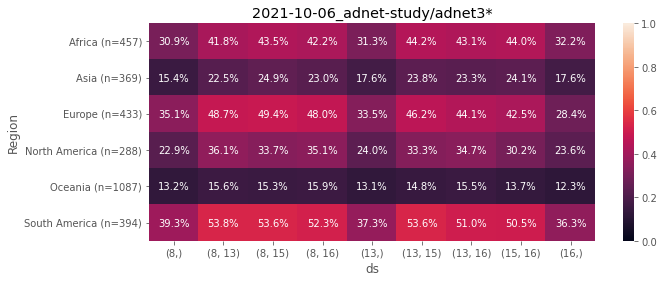

In [56]:
f, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(
    df_user_vuln,
    annot=True,
    fmt='.1%',
    ax=ax,
    vmin=0,
    vmax=1,
)
plt.title('2021-10-06_adnet-study/adnet3*')
plt.savefig('adnet3-vulnerabilities-by-region-and-ds-config.pdf')

In [42]:
df_user_vuln = df_requests[df_requests['attack'] != 'mitm-ra'].groupby(['Region', 'token', 'ds']).agg(
    {'vulnerable': [any]}  # aggregation across attacks, hence using any
).reset_index()
df_user_vuln.columns = df_user_vuln.columns.droplevel(1)
df_user_vuln = df_user_vuln.pivot(index=['Region', 'token'], columns=['ds'], values=['vulnerable'])
df_user_vuln.head(20).style.apply(lambda row: ['background-color: red;' if val else '' for val in row], axis=1)

/home/nils/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [43]:
df_user_behaviors = df_user_vuln.reset_index().groupby(list(sorted(df_user_vuln.keys()))).agg({('token', ''): ['count']}).reset_index().sort_values(('token', '', 'count'), ascending=False)
df_user_behaviors.head(30).style.apply(lambda row: ['background-color: red;' if val < 1 else '' for val in row], axis=1).format(lambda v: f"{v:n}")

In [44]:
len(df_requests['token'].unique())

3028

In [45]:
df_user_behaviors = df_user_vuln.reset_index().groupby(list(sorted(df_user_vuln.keys()))).agg({('token', ''): ['count']}).reset_index().sort_values(('token', '', 'count'), ascending=False)
df_user_behaviors.head(30).style.apply(lambda row: ['background-color: red;' if val < 1 else '' for val in row], axis=1).format(lambda v: f"{v:n}")

In [46]:
behaviors = sorted()
df_user_vuln['behavior'] = df_user_vuln.apply(lambda row: ''.join(['0' if row[k] < 1 else '1' for k in behaviors]), axis=1)

TypeError: sorted expected 1 argument, got 0

In [ ]:
df_user_vuln.reset_index().groupby(['behavior']).agg({('token', '', ''): ['count']}).reset_index().sort_values(('token', '', '', 'count'), ascending=False).head(30)

In [ ]:
behaviors[-6]